In [1]:
# Magic commands
%matplotlib inline

# External packages
import os
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from qutip import *
from pylab import *
from ipywidgets import widgets
from IPython.display import display, HTML

# cQED modules
from plotsettings import *
from plots import *
from supports import *
from process import *
from calculate import *
from envelopes import *
from scan import *

home = os.getcwd() + "/"
print(home)

/home/jovyan/thesis/


In [97]:
# Device 
Nq = 10         # number of levels in qubit
Nc = 10         # number of levels in resonator 1
Nh = 10
wq = 6.807 *2*pi  # g-e qubit transition frequency
wc = 4.09 *2*pi  # bare resonator frequency
wh = 12.0 *2*pi
Ec = 0.138 *2*pi  # anharmonicity (charging energy)
g  = 0.198 *2*pi  # coupling between qubit and resonator
gh = 0.6 *2*pi
kq = 129e-6 *2*pi  # qubit linewidth
kc = 0.01 *2*pi  # cavity linewidth

# Anharmonicity approximation
anh_appr = False  # remove off-diagonal elements from H_anh?
anh_power = 4

# Sideband transitions
sb = 'red'  # type of sideband transitions
Nt = 1      # number of drive tones

# Single-tone
eps = 0.5 *2 *2*pi  # pump drive amplitude
wd  = 1.3174 *2*pi  # monochromatic drive frequency

# Double-tone
epsfac = 1.0                     # factor with which to scale the drive tone amplitudes
epsq   = epsfac * 0.025 *2 *2*pi  # amplitude of qubit-friendly drive tone
epsc   = epsfac * 0.317 *2 *2*pi  # amplitude of cavity-friendly drive tone
dw     = 0.5 *2*pi               # detuning of wdc from wc
wdq    = 4.4799 *2*pi            # frequency of qubit-friendly drive tone
wdc    = wc - dw                 # frequency of cavity-friendly drive tone

# Time cycle
t0 = 0         # start of simulation
t1 = t0 + 0    # start of drive and coupling
t2 = t1 + 500  # end of drive of drive and coupling
t3 = t2 + 0    # end of simulation

# Gaussian rise and fall
tg = 10         # length of gaussian rise and fall
gauss = True    # whether or not to rise and fall with gaussian
smooth = False  # whether to start gaussian at 0 or with small jump
Q = 3           # number of std's in gaussian rise and fall

# Convergent method
convergent = False  # use convergent method

# Integration
method = 'bdf'  # mesolve's integration method, either 'bdf' or 'adams'

In [98]:
b, a, c, nq, nc, nh = ops(Nq, Nc, Nh)  # Operators
Ej = (wq + Ec)**2 / (8*Ec)  # Josephson energy

# Individual Hamiltonian terms
if anh_appr or Nq == 2:
    Hi = wq*nq + wc*nc + wh*nh - Ec/2*b.dag()*b.dag()*b*b  # devices intrinsic
else:
    Hi = (wq+Ec)*nq + wc*nc +wh*nh - Ec/12*(b + b.dag())**4
    if anh_power == 6:
        Hi += np.sqrt(2)/360*Ec*np.sqrt(Ec/Ej)*(b + b.dag())**6
Hc = g*(a + a.dag())*(b + b.dag()) + gh*(c + c.dag())*(b + b.dag())  # coupling
if Nt == 1:
    Hd = eps*(b + b.dag())    # single-tone drive
elif Nt == 2:
    Hdq = epsq*(b + b.dag())  # double-tone qubit-friendly drive
    Hdc = epsc*(b + b.dag())  # double-tone cavity-friendly drive

# Combine terms to complete Hamiltonian and include time dependence
if Nt == 1:
    H = [Hi, [Hc, drive_nonosc], [Hd, drive]]  # monochromatic drive
elif Nt == 2:
    H = [Hi, [Hc, drive_nonosc], [Hdq, driveq], [Hdc, drivec]]  # bichromatic drive

# Store time dependence arguments for solver
if Nt == 1:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q'  : Q, 'gauss' : gauss,
              'smooth' : smooth, 'convergent' : convergent, 'Nt' : Nt, 'wd' : wd}
elif Nt == 2:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q'  : Q, 'gauss' : gauss,
              'smooth' : smooth, 'convergent' : convergent, 'Nt' : Nt, 'wdq' : wdq, 'wdc' : wdc}

In [94]:
EE = (Hi+Hc).eigenenergies()/2/pi
print(EE-EE[0])

[  0.           4.0709955    6.72126078   8.14197838  10.78937989
  12.05042631  12.21294861  13.29254     14.85747478  16.12140391
  16.28390612  17.35683676  18.76967013  18.92554531  19.70341402
  20.19236884  20.35485086  21.42108739  22.83776629  22.99359132
  23.76256064  24.10084561  24.26332106  24.42578279  25.33889317
  25.48529179  25.94379308  26.90583813  27.06161266  27.82165069
  28.17180529  28.33426052  28.49670301  29.4031601   29.54944987
  29.99716661  30.81807288  30.9738855   31.12960918  31.74770054
  31.8806893   32.02020383  32.24275224  32.40518716  32.56787553
  33.46738111  33.61356157  34.05080593  34.88614607  35.04190824
  35.19758628  35.80683509  35.93968196  36.07595189  36.15125792
  36.31368644  36.47610094  36.67534542  37.38524042  37.53155615
  37.67762699  37.9865508   38.02043592  38.10474391  38.95419483
  39.10990621  39.2665392   39.86591815  39.9986345   40.13343991
  40.22219964  40.38460782  40.54700299  41.44947775  41.59568518
  41.74166

In [96]:
print(EE[1]-EE[0])
print(EE[4]-EE[2])
print(EE[1]-EE[0])
print(EE[8]-EE[1])

4.07099549693645
4.068119106203715
4.07099549693645
10.786479287856316


In [88]:
def drivefreq(Nq, wq, wc, H, sb, Nt, **kwargs):
    """
    Estimates the required driving frequency or frequencies to induce two-photon
    sideband transitions between a dispersively coupled qubit and cavity, given
    the system's parameters and time-independent Hamiltonian. The dispersive coupling
    shift is calculated by diagonalization of this time-independent Hamiltonian
    without driving terms. The qubit's additional shift due to driving is calculated
    with the analytical formula of the AC-Stark shift and Bloch-Siegert shift.
    The total deviation of the required driving frequency is assumed to be the
    sum of these two effects.
    
    This function can distinguish between 8 cases, each of which is a combination
    of the following three settings:
    - TLS (two qubit levels) or Transmon (more than two qubit levels);
    - monochromatic or bichromatic driving;
    - red (e0-g1) or blue (e1-g0) sideband transitions.
    
    Assumptions:
    - The qubit and cavity are dispersively coupled with sufficient detuning, but
      wq < 2*wc and wc < 2*wq.
    - With bichromatic driving, the cavity-friendly drive tone wdc is fixed in
      frequency. The qubit-friendly tone wdq is to be estimated.
    
    Performance:
    - At least accurate to MHz for low driving amplitudes in the transmon case,
      or single-tone TLS case.
    - At least accurate to 10 MHz for double-tone TLS case.
    - Here used second-order perturbative approach not sufficient for large driving
      amplitudes.
    
    
    Input
    -----
    Nq : int
        Number of qubit levels
    wq : float
        Qubit frequency [Grad/s]
    wc : float
        Cavity frequency [Grad/s]
    H : qutip.qobj.Qobj
        Time-independent Hamiltonian including the intrinsic terms of the qubit
        and cavity, and thee coupling term
    sb : str
        Type of sideband transition, either 'red' (e0-g1) or 'blue' (e1-g0)
    Nt : int
        Number of drive tones
    **kwargs
        Available arguments:
        'lower' : float
            Lower bound of possible drive frequencies [Grad/s]
        'upper' : float
            Upper bound of possible drive frequencies [Grad/s]
        'resolution' : float
            Resolution within range of possible drive frequencies
        'dw' : float
            Detuning of cavity-friendly drive tone from uncoupled cavity frequency
            [Grad/s]
        'Ec' : float
            Qubit's anharmonicty [Grad/s]
        'eps' : float
            Drive amplitude when driving monochromatically [Grad/s]
        'epsq' : float
            Amplitude of qubit-friendly drive tone when driving bichromatically
            [Grad/s]
        'epsc' : float
            Amplitude of cavity-friendly drive tone when driving bichromatically
            [Grad/s]
        'method' : str
            Analytical formula to calculate shift of qubit levels due to dispersive
            driving, either 'SBS'/'sbs' (ac-Stark + Bloch-Siegert shift) or 'SW'
            (in displaced frame of drive after Schriffer-Wolff transformation)
        'anharm' : str
            Linearity of transmon's anharmonicity. Linear anharmoncity corresponds
            to performing RWA on anharmonicty term (b + b.dag)**4 (removes all off-
            diagonal elements). Nonlinear leaves this fourth-power term untouched.
            Either 'lin'/'linear' or 'nonlin'/'nonlinear'.
        'verbose' : bool
            Print estimated drive frequency or frequencies
    
    
    Returns
    -------
    wd_estimate : float
        Estimated monochromatic drive frequency [Grad/s]
    wdq_estimate : float
        Estimated qubit-friendly drive tone frequency when driving bichromatically
        [Grad/s]
    wdc : float
        Cavity friendly drive tone frequency when driving bichromatically [Grad/s]
    """
    
    # Handle method argument
    if 'method' in kwargs and kwargs['method'] == 'sbs':
        kwargs['method'] = 'SBS'
    if 'method' in kwargs and kwargs['method'] == 'sw':
        kwargs['method'] = 'SW'
    elif 'method' not in kwargs:
        kwargs['method'] = 'SBS'  # default
    
    if kwargs['method'] not in ('SBS', 'SW'):
        raise ValueError("Unknown method")
    
    if kwargs['method'] == 'SW' and Nt == 2:
        raise ValueError("Schrieffer-Wolff transformation not available for bichromatic driving")
    if kwargs['method'] == 'SW' and Nq <= 2:
        raise ValueError("Schrieffer-Wolff transformation not available for two-level system")
    
    # Handle anharmonicity argument
    if 'anharm' in kwargs and kwargs['anharm'] == 'linear':
        kwargs['anharm'] = 'lin'
    elif 'anharm' in kwargs and kwargs['anharm'] == 'nonlinear':
        kwargs['anharm'] = 'nonlin'
    elif 'anharm' not in kwargs:
        kwargs['anharm'] = 'lin'  # default
    
    if kwargs['anharm'] not in ('lin', 'nonlin'):
        raise ValueError("Invalid anharm argument")
    
    
    # Determine drive frequency range to scan
    # Monochromatic drive
    if Nt == 1:
        if 'lower' in kwargs:
            lower_bound = kwargs['lower']
        else:
            if sb == 'red':
                lower_bound = abs(wq-wc)/2 - 0.4 *2*pi
            elif sb == 'blue':
                lower_bound = abs(wq+wc)/2 - 0.4 *2*pi

        if 'upper' in kwargs:
            upper_bound = kwargs['upper']
        else:
            if sb == 'red':
                upper_bound = abs(wq-wc)/2 + 0.4 *2*pi
            elif sb == 'blue':
                upper_bound = abs(wq+wc)/2 + 0.4 *2*pi

        if 'resolution' in kwargs:
            resolution = kwargs['resolution']
        else:
            resolution = 0.0001 *2*pi

        wd_range = np.arange(lower_bound, upper_bound, resolution)
    
    # Bichromatic drive
    elif Nt == 2:
        if 'dw' in kwargs:
            dw = kwargs['dw']
        else:
            dw = 0.5 *2*pi
        
        if 'lower' in kwargs:
            lower_bound = kwargs['lower']
        else:
            if sb == 'red':
                lower_bound = wq - dw - 1.0 *2*pi
            elif sb == 'blue':
                lower_bound = wq + dw - 1.0 *2*pi

        if 'upper' in kwargs:
            upper_bound = kwargs['upper']
        else:
            if sb == 'red':
                upper_bound = wq - dw + 1.0 *2*pi
            elif sb == 'blue':
                upper_bound = wq + dw + 1.0 *2*pi

        if 'resolution' in kwargs:
            resolution = kwargs['resolution']
        else:
            resolution = 0.0001 *2*pi

        wdq_range = np.arange(lower_bound, upper_bound, resolution)
        wdc = wc - dw
    
    
    # Calculate dispersive driving shift by using the AC-Stark shift
    # and Bloch-Sieger shift
    # Monochromatic drive
    if Nt == 1:
        eps = kwargs['eps']
        
        # TLS
        if Nq == 2:
            drive_shifts = eps**2/2*(1/(wq-wd_range) + 1/(wq+wd_range))
        
        # Transmon
        elif Nq > 2:
            Ec = kwargs['Ec']
            
            # Direct AC-Stark shift + Bloch-Siegert shift
            if kwargs['method'] == 'SBS':
                drive_shifts = eps**2/2*(1/(wq-wd_range) + 1/(wq+wd_range) - 1/(wq-Ec-wd_range) - 1/(wq-Ec+wd_range))
            
            # Frequency modulation in displaced drive frame
            elif kwargs['method'] == 'SW':
                pass  # shift by driving is calculated from diagonalization of the Hamiltonian

    # Bichromatic drive
    elif Nt == 2:
        epsq = kwargs['epsq']
        epsc = kwargs['epsc']
        
        # TLS
        if Nq == 2:
            drive_shifts = epsq**2/2*(1/(wq-wdq_range) + 1/(wq+wdq_range)) + epsc**2/2*(1/(wq-wdc) + 1/(wq+wdc))
        
        # Transmon
        elif Nq > 2:
            Ec = kwargs['Ec']
            ge_shifts = epsq**2/2*(1/(wq-wdq_range) + 1/(wq+wdq_range)) + epsc**2/2*(1/(wq-wdc) + 1/(wq+wdc))
            ef_shifts = epsq**2*(1/(wq-Ec-wdq_range) + 1/(wq-Ec+wdq_range)) + epsc**2*(1/(wq-Ec-wdc) + 1/(wq-Ec+wdc))
            drive_shifts = ge_shifts - ef_shifts/2
    
    
    # Calculate dispersive coupling shift by diagonalizing the time-independent,
    # Hamiltonian, subject to the qubit shift by driving
    if 'Nc' in kwargs.keys():
        Nc = kwargs['Nc']
    else:
        Nc = 10  # default
    if 'Nh' in kwargs.keys():
        Nc = kwargs['Nh']
    else:
        Nc = 10  # default
    b, _, _, nq, _, _ = ops(Nq, Nc, Nh)  # Operators
    
    dev_red  = list()
    dev_blue = list()
    
    # Transmon, monochromatic driving, frequency modulation after Schrieffer-Wolff transformation
    if Nq > 2 and Nt == 1 and kwargs['method'] == 'SW':
        for wd in wd_range:
            Delta = wd - wq
            Sigma = wd + wq
            
            selfinteraction = -eps**2/(2*Delta*Sigma)*(b.dag()*b.dag() + b*b)
            selfinteraction += 4*((eps/(2*Delta))**2 + (eps/(2*Sigma))**2)*b.dag()*b
            H_shifted = H - Ec/2*selfinteraction
            EE = H_shifted.eigenenergies()
            Eg0 = EE[0]
            if wq > wc:
                Eg1 = EE[1]
                Ee0 = EE[2]
            elif wq < wc:
                Eg1 = EE[2]
                Ee0 = EE[1]
            Ee1 = EE[4]  # E(f0) > E(e1)
            dev_red.append((Ee0 - Eg1) - (wq - wc))
            dev_blue.append((Ee1 - Eg0) - (wq + wc))

    # All other cases
    else:
        for drive_shift in drive_shifts:
            H_shifted = H + drive_shift*nq
            EE = H_shifted.eigenenergies()
            Eg0 = EE[0]
            if wq > wc:
                Eg1 = EE[1]
                Ee0 = EE[2]
            elif wq < wc:
                Eg1 = EE[2]
                Ee0 = EE[1]
            if Nq == 2 and wq < wc:
                Ee1 = EE[3]  # E(f0) < E(e1)
            else:
                Ee1 = EE[4]  # E(f0) > E(e1)
            dev_red.append((Ee0 - Eg1) - (wq - wc))
            dev_blue.append((Ee1 - Eg0) - (wq + wc))
    
    
    # Calculate the frequency deviation for every wd in wd_range
    # Monochromatic drive
    if Nt == 1:
        if sb == 'red':
            diff = abs(wq + np.asarray(dev_red) - wc)/2 - wd_range
        elif sb == 'blue':
            diff = (wq + np.asarray(dev_blue) + wc)/2 - wd_range
        diff = abs(diff)

        wd_estimate = wd_range[diff.tolist().index(min(abs(diff)))]
        if 'verbose' in kwargs and kwargs['verbose']:
            print("Estimated drive frequency wd = {} GHz".format(np.round(wd_estimate/2/pi, 4)))
        return wd_estimate
    
    # Bichromatic drive
    elif Nt == 2:
        if sb == 'red':
            diff = abs(wq + dev_red - wc) - abs(wdq_range - wdc)
        elif sb == 'blue':
            diff = (wq + dev_blue + wc) - (wdq_range + wdc)
        diff = abs(diff)
        wdq_estimate = wdq_range[diff.tolist().index(min(abs(diff)))]
        
        if 'verbose' in kwargs and kwargs['verbose']:
            print("Estimated qubit-friendly drive frequency wdq  = {} GHz".format(np.round(wdq_estimate/2/pi, 4)))
            print("Cavity-friendly drive frequency          wdc  = {} GHz".format(np.round(wdc/2/pi, 4)))
        return wdq_estimate, wdc

In [89]:
# Estimate the required drive frequency
_ = drivefreq(Nq, wq, wc, Hi+Hc, sb, Nt, eps=eps, epsq=epsq, epsc=epsc, dw=dw, Ec=Ec,
              resolution=0.001*2*pi, verbose=True, method='SW', anharm='nonlin')

Estimated drive frequency wd = 1.3235 GHz


In [99]:
# Set the initial state based on the type of sideband transition
if sb == 'red':
    psi0 = tensor(basis(Nq, 1), basis(Nc, 0), basis(Nh, 0))  # Red: qubit excited, cavity in ground state
elif sb == 'blue':
    psi0 = tensor(basis(Nq, 0), basis(Nc, 0), basis(Nh, 0))  # Blue: both qubit and cavity in ground state

# Set the expectation and collapse operators for the solver
e_ops = [nq, nc, nh]  # expectation operators
c_ops = []        # collapse operators

# Set the options for the Lindblad ME solver
options = Options()
options.store_states=True
if method == 'bdf':
    options.method = 'bdf'
    options.rtol = 1e-10
    options.atol = 1e-10
else:  # adams
    options.nsteps = 1000
    options.rtol = 1e-10
    options.atol = 1e-10
    options.max_step = 0

# Set the time steps for which to store the output of the solver
if not convergent:
    Np = 50 *int(t3)  # number of equidistant data points in time
    print("timestep =", 1e3*np.round(t3/Np, 5), "ps")
elif convergent:
    Np = 2 *int(t3)    # number of equidistant data points in time
    print("timestep =", 1e3*np.round((t3-2*tg)/Np, 5), "ps")
Np_per_batch = Np/int(np.round(t3/10))  # number of time points per batch

timestep = 20.0 ps


In [100]:
def combined_probs(states, Nc, Nh):
    inds = ((1,0), (0,1), (1,1), (0,0))
    probs = list()
    [probs.append(list()) for i in range(len(inds))]
    print("1")
    for i, ind in enumerate(inds):
        print("ind {}".format(i))
        for state in states:
            ptraced_state = state.ptrace([0, 1]).diag().reshape(Nq*Nc,1)
            probs[i].append((ptraced_state.data[ind[1] + Nc*ind[0], 0]*np.conj(ptraced_state.data[ind[1] + Nc*ind[0], 0])).real)
    print("2")
    e0 = np.asarray(probs[0])
    g1 = np.asarray(probs[1])
    e1 = np.asarray(probs[2])
    g0 = np.asarray(probs[3])
    return e0, g1, e1, g0

In [101]:
def calculate(H, psi0, e_ops, c_ops, H_args, options, Nc, Np, Np_per_batch, home,
              parallel=False, verbose=True, **kwargs):
    """
    Integrate through time evolution using qutip's Lindblad master equation solver.
    
    Input
    -----
    H : list
        Full Hamiltonian. Time-dependent terms must be given as
        [qutip.Qobj, callback function].
    psi0 : qutip.Qobj class object
        Initial state
    e_ops : list of qutip.Qobj class objects
        Operators for which to evaluate the expectation value
    c_ops : list of qutip.Qobj class objects
        Collapse operators
    H_args : dict
        Parameters for time-dependent Hamiltonians and collapse operators
    options : qutip.Options class object
        Options for the solver
    Nc : int
        Number of cavity levels
    Np : int
        Number of points for which to store the data
    Np_per_batch : int, float
        Number of points per batch
    home : str
        Path to folder with source code
    parallel : bool
        Whether multiple simulations are run in parallel
    verbose : bool
        Print progress
    
    Returns
    -------
    folder : str
        Folder name in which the evolution is stored
    """
    Np = int(np.round(Np))
    N_devices = len(psi0.dims[0])
    t0 = H_args['t0']
    t3 = H_args['t3']
    
    if verbose:
        update_progress(0)
    
    ID, folder, now = prepare_folder(home, parallel)
    
    # Regular evolution with master equation solver
    if not H_args['convergent'] and kwargs['method'] == 'me':
        batches = create_batches(t0, t3, Np, Np_per_batch)
        
        for num, tlist in enumerate(batches):
            result = mesolve(H, psi0, tlist, c_ops=c_ops, e_ops=e_ops, args=H_args, options=options)
            
#             e0, g1, e1, g0 = combined_probs(result.states, Nc, Nh)
           
            coupling = drive_nonosc(tlist, H_args)  # unitless, peaks at 1
            
            if verbose:
                update_progress((num+1)/len(batches))
            
#             saveprog(result, e0, g1, e1, g0, coupling, num, folder)
            saveprog(result, None, None, None, None, coupling, num, folder)
            
            psi0 = copy(result.states[-1])
            
            del result, coupling
    
    end_calc = datetime.now()
    if verbose:
        print("Evolution completed in {} min".format((end_calc - now) // timedelta(minutes=1)))
    
    return folder

In [66]:
progfolder = calculate(H, psi0, e_ops, c_ops, H_args, options, Nc, Np, Np_per_batch, home,
                       parallel=False, verbose=True, refinement=10, method='me')

Progress: |██████████████████████████████████████████████████| 100.0%
Evolution completed in 13 min


In [67]:
# Save the parameters that are used
if Nt == 1:
    saveparams(Nq, Nc, Nt, wq, 0, wc, Ec, g, sb, t0, t1, t2, t3, tg, anh_appr, gauss, smooth, Q, convergent,
               Np, H, psi0, e_ops, options, progfolder, frmt=['pkl', 'txt'], eps=eps, wd=wd)
elif Nt == 2:
    saveparams(Nq, Nc, Nt, wq, 0, wc, Ec, g, sb, t0, t1, t2, t3, tg, anh_appr, gauss, smooth,
               Q, convergent, Np, H, psi0, e_ops, options, progfolder, frmt=['pkl', 'txt'],
               epsq=epsq, epsc=epsc, wdq=wdq, wdc=wdc, dw=dw)

In [68]:
# Load parameters
srcfolder = progfolder  # path to the folder to get the data from

start_comb = datetime.now()
new_folder_name = copy(srcfolder)
ID = getID(srcfolder)  # unique simulation ID

# Get the parameters that are used
Nq, Nc, Nt, wq, _, wc, Ec, g, sb, t0, t1, t2, t3, tg, anh_appr, gauss, smooth, Q, convergent, Np, H, psi0, e_ops, options, eps, wd, epsq, epsc, dw, wdq, wdc = getparams(srcfolder)
if Nt == 1:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q' : Q,
              'gauss' : gauss, 'smooth' : smooth, 'convergent' : convergent, 'Nt' : Nt, 'wd' : wd}
elif Nt == 2:
    H_args = {'t0' : t0, 't1' : t1, 't2' : t2, 't3' : t3, 'tg' : tg, 'Q' : Q, 'gauss' : gauss,
              'smooth' : smooth,  'convergent' : convergent, 'Nt' : Nt, 'wdq' : wdq, 'wdc' : wdc}

In [69]:
# Combine all batches per quantity
quants = ['times', 'expect', 'e0', 'g1', 'e1', 'g0', 'coupling']  # quantities to extract from data folder
quants = ['times', 'expect', 'coupling']

combine_batches(srcfolder, quants=quants, return_data=False)
print("Batches combined    in {} s".format((datetime.now() - start_comb).total_seconds()))

times, states, expect, e0, g1, e1, g0, coupling = load_data(quants, srcfolder)  # load to RAM

Batches combined    in 6.004907 s


In [70]:
# # Determine the sideband transition rate
# smoothen_method = 'savgol'  # method to remove micromotion, either 'savgol', 'bisect', or 'lowpass'

# if not convergent:
#     if 'e0' in quants:
#         e0_macro, e0_macro_times = remove_micromotion(e0, times, method=smoothen_method)
#     if 'g0' in quants:
#         g0_macro, g0_macro_times = remove_micromotion(g0, times, method=smoothen_method)
#     if 'e1' in quants:
#         e1_macro, e1_macro_times = remove_micromotion(e1, times, method=smoothen_method)
#     if 'g1' in quants:
#         g1_macro, g1_macro_times = remove_micromotion(g1, times, method=smoothen_method)
#     if ('e1' in quants and 'g0' in quants):
#         e1g0_macro, e1g0_macro_times = remove_micromotion(e1-g0, times, method=smoothen_method)
#     if ('e0' in quants and 'g1' in quants):
#         e0g1_macro, e0g1_macro_times = remove_micromotion(e0-g1, times, method=smoothen_method)

#     if sb == 'red':
#         wsb = sideband_freq(e0g1_macro, e0g1_macro_times)
#     elif sb == 'blue':
#         wsb = sideband_freq(e1g0_macro, e1g0_macro_times)

# elif convergent:
#     if sb == 'red':
#         wsb = sideband_freq(e0-g1, times)
#     elif sb == 'blue':
#         wsb = sideband_freq(e1-g0, times)

# print("sideband transition freq   wsb = {} GHz".format(wsb/2/pi))
# if wsb > 0:
#     print("sideband transition period Tsb = {} ns".format(2*pi/wsb))

In [71]:
# Determine the sideband transition rate
smoothen_method = 'savgol'  # method to remove micromotion, either 'savgol', 'bisect', or 'lowpass'

q_macro, q_macro_times = remove_micromotion(expect[0], times, method=smoothen_method)
c_macro, c_macro_times = remove_micromotion(expect[1], times, method=smoothen_method)
wsb = sideband_freq(c_macro, c_macro_times)

print("sideband transition freq   wsb = {} GHz".format(wsb/2/pi))
if wsb > 0:
    print("sideband transition period Tsb = {} ns".format(2*pi/wsb))

         increase the simulation time for a more accurate result
sideband transition freq   wsb = 0.001479435436146289 GHz
sideband transition period Tsb = 675.9335186703736 ns


# 4. Plot evolution
All these calculations and simulations are very nice of course, but let's now see what actually happens. We will plot the evolution in two different ways here:
- the expectation values of both the qubit and the cavity,
- the combined probability $P({\left|e0\right>}) - P({\left|g1\right>})$ in the case of red sideband transitions and $P({\left|e1\right>}) - P({\left|g0\right>})$ in the case of blue.

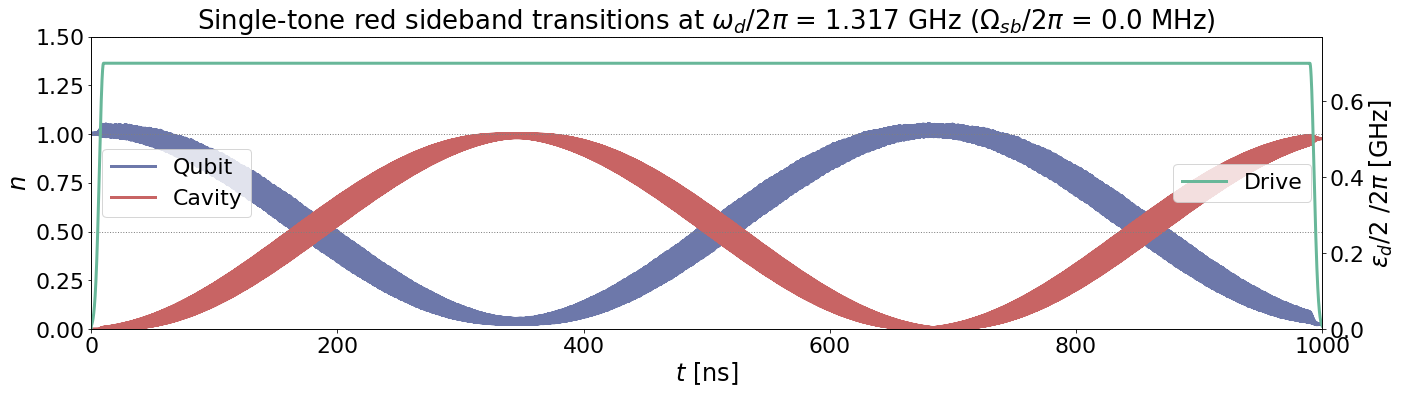

In [72]:
# Plot expectation values
xlim = None       # range of horizontal axis
ylim = None       # range of vertical axis
figsize = [20,6]  # figure size
wsb = 0

if sb == 'red':
    if Nt == 1:
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          wsb=wsb, eps=eps, wd=wd)
    elif Nt == 2:
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          wsb=wsb, epsq=epsq, epsc=epsc)
elif sb == 'blue':
    if Nt == 1:
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          wsb=wsb, eps=eps, wd=wd)
    elif Nt == 2:
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                          wsb=wsb, epsq=epsq, epsc=epsc)

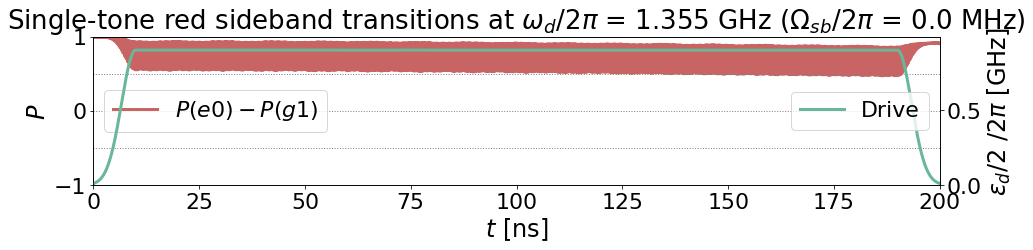

In [22]:
# Plot combined probabilities
xlim = None       # range of horizontal axis
ylim = None       # range of vertical axis
figsize = [15,4]  # figure size

if sb == 'red':
    if Nt == 1:
        fig, axp = sb_combined_probs(times, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                                e0=e0, g1=g1, wd=wd, wsb=wsb, eps=eps)
    elif Nt == 2:
        fig, axp = sb_combined_probs(times, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                                e0=e0, g1=g1, wsb=wsb, epsq=epsq, epsc=epsc)
elif sb == 'blue':
    if Nt == 1:
        fig, axp = sb_combined_probs(times, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                                e1=e1, g0=g0, wd=wd, wsb=wsb, eps=eps)
    elif Nt == 2:
        fig, axp = sb_combined_probs(times, sb, Nt, H_args, coupling, xlim=xlim, ylim=ylim, figsize=figsize,
                                e1=e1, g0=g0, wsb=wsb, epsq=epsq, epsc=epsc)

# 5. Save data and plots
If we are satisfied with the simulation and we want to save it for later, click the button below which sais "Save data". This saves all the information, including the entire evolution, quantity files and the two above figures, to a new folder in the '/data/' folder, and removes the old temporary folder. The new folder's name contains the simulation ID and some basis parameter values. Furthermore, the sideband transition rate is added to the "parameter.txt" file.

In [15]:
# Save all data and plots with a single click on the button!
data_saved = False
data_button = widgets.Button(description='Save data')
data_out = widgets.Output()
def data_clicked(b):
    data_button.description = 'Data saved!'
    with data_out:
        global srcfolder
        
        parfile = open(srcfolder + "/parameters.txt", "a+")
        parfile.write("sideband transition frequency   wsb    : {} = {} GHz\n".format(wsb, wsb/2/pi))
        parfile.write("sideband transition coupling    gsb    : {} = {} GHz".format(wsb/2, wsb/2/2/pi))
        parfile.close()
                
        if Nt == 1:
            new_folder_name = home + "data/data_{}_{}_Nq{}_Nt{}_eps{}_wd{}_wq{}_wc{}_wsb{}".format(
                              ID, sb, Nq, Nt, round(eps/2/pi, 2), round(wd/2/pi, 3), round(wq/2/pi, 2),
                              round(wc/2/pi, 2), round(wsb/2/pi, 4))
            figqc.savefig(srcfolder + "/" + "figqc_{}.png".format(ID, bbox_inches='tight'))
            fig.savefig(srcfolder + "/" + "fig_{}.png".format(ID, bbox_inches='tight'))
        elif Nt == 2:
            new_folder_name = home + "data/data_{}_{}_Nq{}_Nt{}_epsq{}_wdq{}_epsc{}_wdc{}_dw{}_wq{}_wc{}_wsb{}".format(
                              ID, sb, Nq, Nt, round(epsq/2/pi, 2), round(wdq/2/pi, 3), round(epsc/2/pi, 2),
                              round(wdc/2/pi, 3), round(dw/2/pi, 1), round(wq/2/pi, 2),
                              round(wc/2/pi, 2), round(wsb/2/pi, 4))
            figqc.savefig(srcfolder + "/" + "figqc_{}.png".format(ID, bbox_inches='tight'))
            fig.savefig(srcfolder + "/" + "fig_{}.png".format(ID, bbox_inches='tight'))
        os.rename(srcfolder, new_folder_name)
        print("Folder renamed to", new_folder_name)
        srcfolder = new_folder_name
data_button.on_click(data_clicked)
widgets.VBox([data_button, data_out])

In [43]:
initpsi = tensor(basis(2,0), basis(2,0), basis(2,0))
print(initpsi.ptrace([0, 1]).diag().reshape(4,1))

[[1.]
 [0.]
 [0.]
 [0.]]


# A. Scanning

## I. Sideband transitions
For all the above, the frequency has to be given. But in order to find the correct driving frequency $\omega_d$ that induces sideband transitions we could like to sweep the driving frequency around the estimated required frequency. For every $\omega_d$ a simulation is performed with the parameters set in section 1. Parameters. The frequency range is given by `wds`. To speed up the calculation time, simulations can be run in parallel. `Npool` is the number of parallel simulations, which is of course limited by the number of available cores.

The function `sbsample` outputs two plots for every simulation with a print of the corresponding driving frequency, global maximum value of the combined probability and the global minimum. Note that before beginning the calculations, all existing folders and figures in the '/temp/' folder are deleted.

In [102]:
def sbsample(Nq, wq, wc, Ec, g, wd, sb, Nt, H, H_args, psi0, Np_per_batch,
             options, home, parallel, *args):
    """
    Performs a single- or double-tone sideband transition simulation
    with the given input parameters. Plots the expectation
    values of the qubit & cavity, and the combined probability
    |e0>-|g1> in the case of red sideband transitions, or
    |e1>-|g0> in the case of blue sideband transitions.
    
    Due to the use of the pool.starmap function, the additional
    arguments of *args, dependent on Nt, have to be passed in
    a definite order.
    Nt = 1 : eps
    Nt = 2 : epsq, epsc, dw
    
    Input
    -----
    The input parameters are equal to the names in 2p_sideband.ipynb.
    
    Returns
    -------
    figqc : matplotlib.pyplot.Figure class object
        Figure with expected qubit and cavity occupation number
    fig : matplot.pyplot.Figure class object
        Figure with combined probabilities
    """
    from envelopes import drive
    
    i = wd[0]
    wd = wd[1]
    
    Nc = 10  # number of levels in resonator 1
    Nh = 10
    
    Np = 100*int(H_args['t3'])  # number of discrete time steps for which to store the output
    b, a, c, nq, nc, nh = ops(Nq, Nc, Nh)  # Operators
    if Nt == 1:
        H_args['wd'] = wd
    elif Nt == 2:
        dw = args[2]
        wdq = wd
        wdc =  wc - dw
        H_args['wdq'] = wdq
        H_args['wdc'] = wdc
    e_ops = [nq, nc, nh]
    c_ops = []
        
    srcfolder = calculate(H, psi0, e_ops, c_ops, H_args, options, Nc, Np, Np_per_batch,
                          home, parallel, verbose=False, method='me')
    
    quants = ['times', 'expect', 'e0', 'g1', 'e1', 'g0', 'coupling']
    quants = ['times', 'expect', 'coupling']
    ID = getID(srcfolder)
    combine_batches(srcfolder, quants=quants, return_data=False)
    times, states, expect, e0, g1, e1, g0, coupling = load_data(quants, srcfolder)
    
    if i < 10:
        num = "0" + str(i)
    elif i >= 10:
        num = str(i)
    
    print(" ")
    
    eps = args[0]
    print("wd = {}".format(wd/2/pi))
    if sb == 'red':
#             print("min = {}, max = {}".format(round(min(e0-g1), 4), round(max(e0-g1), 4)))
        print("min = {}, max = {}".format(round(min(expect[1]), 4), round(max(expect[1]), 4)))
#             cp_title = "wd = {}, min = {}, max = {}".format(wd/2/pi, round(min(e0-g1), 4), round(max(e0-g1), 4))
        expect_title = "wd = {}, min = {}, max = {}".format(wd/2/pi, round(min(expect[1]), 4), round(max(expect[1]), 4))
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=None, ylim=None, figsize=[15,3],
                          wd=wd, wsb=0, title=expect_title, eps=eps)
#             fig, axp = sb_combined_probs(times, sb, Nt, H_args, coupling,
#                                     e0=e0, g1=g1, wd=wd, wsb=0, title=cp_title, eps=eps)
    elif sb == 'blue':
#             print("min = {}, max = {}".format(round(min(e1-g0), 4), round(max(e1-g0), 4)))
        print("min = {}, max = {}".format(round(min(expect[1]), 4), round(max(expect[1]), 4)))
        expect_title = "wd = {}, min = {}, max = {}".format(wd/2/pi, round(min(expect[1]), 4), round(max(expect[1]), 4))
#         cp_title = "wd = {}, min = {}, max = {}".format(wd/2/pi, round(min(expect[1]), 4), round(max(expect[1]), 4))
        figqc, axqc = sb_expect(times, expect, sb, Nt, H_args, coupling, xlim=None, ylim=None, figsize=[15,3],
                          wd=wd, wsb=0, title=expect_title, eps=eps)
#             fig, axp = sb_combined_probs(times, sb, Nt, H_args, coupling,
#                                     e1=e1, g0=g0, wd=wd, wsb=0, title=cp_title, eps=eps)
#         fig.savefig(home + "temp/fig{}_{}.png".format(num, wd/2/pi))
        figqc.savefig(home + "temp/figqc{}_{}.png".format(num, wd/2/pi))
#     plt.close(fig)
    plt.close(figqc)
#     return figqc, fig
    return figqc

 
wd = 1.3171428571428572
min = 0.0, max = 0.0286


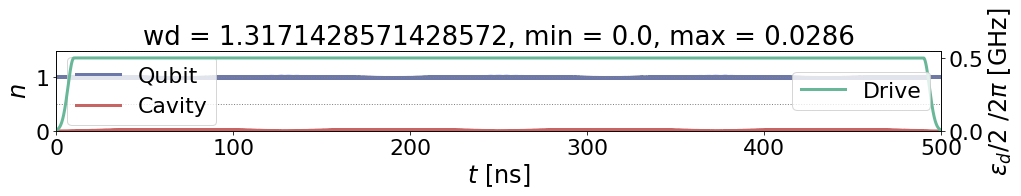

 
wd = 1.3057142857142856
min = 0.0, max = 0.0112


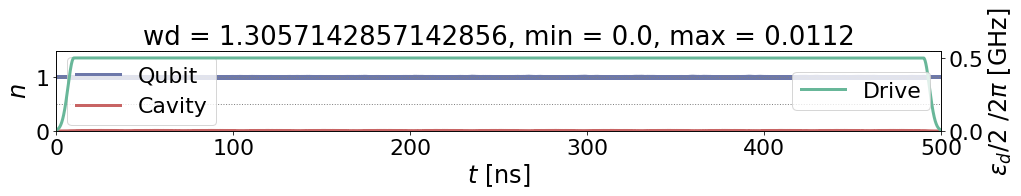

 
wd = 1.3285714285714285
min = 0.0, max = 0.0172


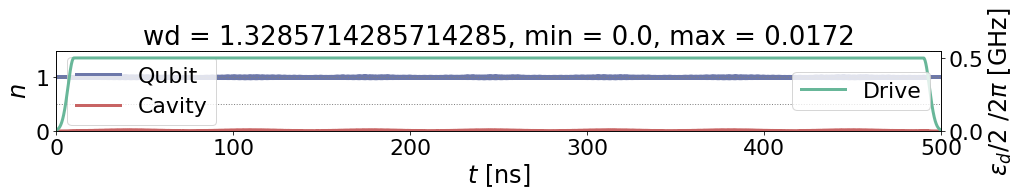

 
wd = 1.322857142857143
min = 0.0, max = 0.0893


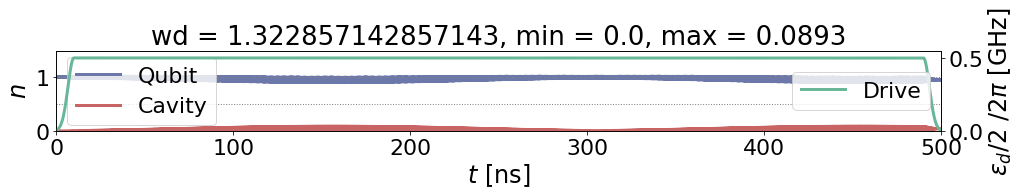

 
wd = 1.3114285714285714
min = 0.0, max = 0.014
 
wd = 1.3
min = 0.0, max = 0.01


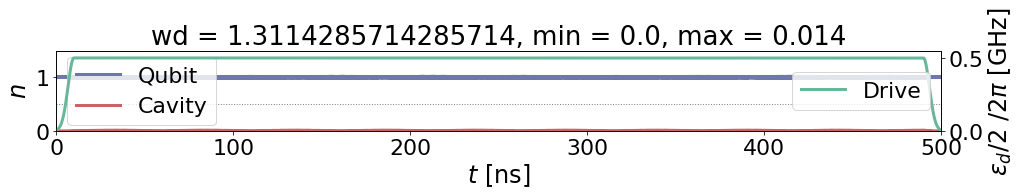

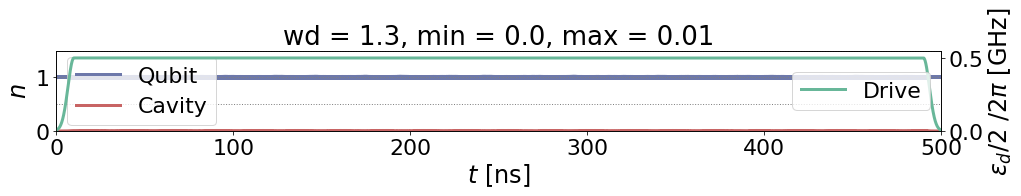

 
wd = 1.3342857142857145
min = 0.0, max = 0.012


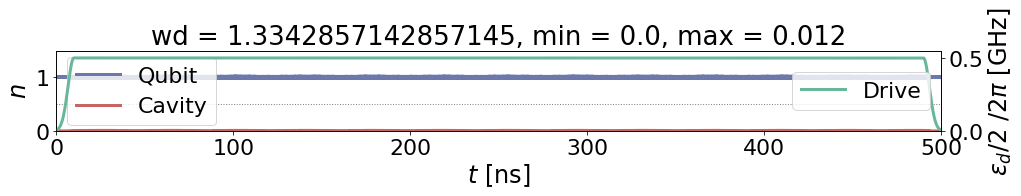

 
wd = 1.34
min = 0.0, max = 0.0102


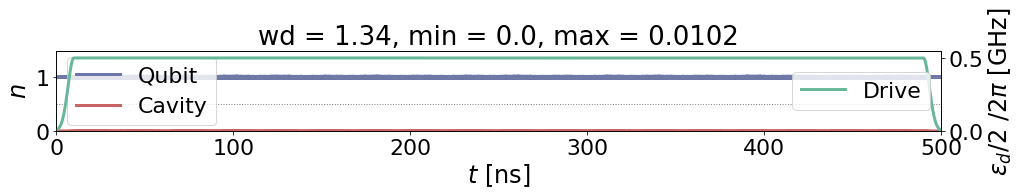

Done.


In [103]:
wds = np.linspace(1.30*2*pi, 1.34*2*pi, 8)  # (qubit-friendly) drive frequency range to scan
Npool = 8  # number of parallel simulations

for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all existing progfiles
for figure in glob(home + "temp/fig*"):
    os.remove(figure)  # delete all existing figures
wds = zip(range(len(wds)), wds)
pool = mp.Pool(Npool)
if Nt == 1:
    pool.starmap(sbsample, [(Nq, wq, wc, Ec, g, Wd, sb, Nt, H, H_args, psi0, Np_per_batch, options, home, True,
                             eps) for Wd in wds])
elif Nt == 2:
    pool.starmap(sbsample, [(Nq, wq, wc, Ec, g, Wd, sb, Nt, H, H_args, psi0, Np_per_batch, options, home, True,
                             epsq, epsc, dw) for Wd in wds])
pool.close()
for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all progfiles
print("Done.")

## II. Qubit frequency
The cell below considers only the qubit with the drive, without the cavity. An additional probe tone scans for resonance with the qubit frequency shifted by the drive. `wps` is the probe frequency range.

In [92]:
wps = np.linspace(wq+0.009*2*pi, wq+0.014*2*pi, 6)  # probe frequency range to scan1
Npool = 6                                       # number of parallel simulations
drive_on = True

for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all existing progfiles
for figure in glob(home + "temp/fig*"):
    os.remove(figure)  # delete all existing figures
wps = zip(range(len(wps)), wps)
pool = mp.Pool(Npool)
b, nq = ops(Nq)
Hq = wq*nq - Ec/2*b.dag()*b.dag()*b*b  # qubit intrinsic
Omegap = 0.005  # amplitude of probe tone
Hp = epsp*(b + b.dag())
if Nt == 1:
    Hd = eps*(b + b.dag())  # single-tone drive
    H = [Hq, [Hd, drive], [Hp, probe]]  # complete Hamiltonian
elif Nt == 2:
    Hdq = epsq*(b + b.dag())  # double-tone qubit-friendly drive
    Hdc = epsc*(b + b.dag())  # double-tone cavity-friendly drive
    H = [Hq, [Hdq, driveq], [Hdc, drivec], [Hp, probe]]  # complete Hamiltonian
if not drive_on:
    H = [Hq, [Hp, probe]]  # complete Hamiltonian
psi0 = basis(Nq, 0)
pool.starmap(qfs, [(Nq, wq, Ec, wp, H, H_args, psi0, Nc, Np, Np_per_batch, options, home, True)
                   for wp in wps])
pool.close()
for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all progfiles
print("Done.")

Done.


## III. Cavity frequency shift
The cell below considers a driven qubit, coupled to the cavity. An additional probe tone to the cavity scans for resonance with the cavity frequency, which is shifted by coupling to the driven qubit. `wps` is the probe frequency range.

In [6]:
wps = np.linspace(wc-0.017*2*pi, wc-0.022*2*pi, 6)  # probe frequency range to scan
Npool = 6                                       # number of parallel simulations
drive_on = True

for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all existing progfiles
for figure in glob(home + "temp/fig*"):
    os.remove(figure)  # delete all existing figures
wps = zip(range(len(wps)), wps)
pool = mp.Pool(Npool)
epsp = 0.005  # amplitude of probe tone
Hp = epsp*(a + a.dag())
if Nt == 1:
    H = [Hjc, [Hc, drive_nonosc], [Hd, drive], [Hp, probe]]  # complete Hamiltonian
elif Nt == 2:
    H = [Hjc, [Hc, drive_nonosc], [Hdq, driveq], [Hdc, drivec], [Hp, probe]]  # complete Hamiltonian
if not drive_on:
    H = [Hjc, [Hc, drive_nonosc], [Hp, probe]]  # complete Hamiltonian
psi0 = tensor(basis(Nq, 0), basis(Nc, 0))  # initial state
pool.starmap(cfs, [(Nq, Nc, wc, Ec, wp, H, H_args, psi0, Np_per_batch, options, home, True)
                   for wp in wps])
pool.close()
for progf in glob(home + "temp/prog_*"):
    shutil.rmtree(progf)  # delete all progfiles
print("Done.")

Done.


# B. Spectrum analysis
To take a look at the level shifts of the system, we can make use of a faster method than rigorously scanning a frequency range, namely spectrum analysis. The emission/absorption spectrum of for example the qubit can be obtained by taking the Fourier transform of the single-time correlation function:

\begin{equation}
    S_q(\omega) = \int_{-\infty}^{+\infty} \left< \hat{b}(t) \hat{b}^\dagger(0) \right> e^{-i\omega t} dt
\end{equation}

For this, some parameters and objects need to be redefined, depending on the situation, which is done in the first cell below. Note that the decay rate must be nonzero to calculate the spectrum.

The returned spectrum contains nonzero values for negative frequencies. The difference between positive and negative frequencies has a nice interpretation, namely that the negative ones correspond to the emission spectrum, and the positive frequencies to the absorption spectrum.

In [514]:
b = destroy(Nq)
nq = b.dag()*b
if anh_appr or Nq == 2:
    Hq = wq*nq - Ec/2*b.dag()*b.dag()*b*b
if not anh_appr:
    Hq = (wq+Ec)*nq - Ec/12*(b + b.dag())**4
H_args = {'t0' : 0, 't1' : 0, 't2' : 1e10, 't3' : 1e10, 'tg' : 10, 'Q'  : 3,
          'gauss' : False, 'smooth' : False, 'convergent' : False, 'Nt' : 1}
if Nt == 1:
    Hd = eps*(b + b.dag())
    H = [Hq, [Hd, drive]]
    H_args['wd'] = wd
elif Nt == 2:
    Hdq = epsq*(b + b.dag())
    Hdc = epsc*(b + b.dag())
    H = [Hq, [Hdq, driveq], [Hdc, drivec]]
    H_args['wdq'] = wdq
    H_args['wdc'] = wdc

kq = 50e-3 *2*pi      # decay rate
c_ops = [sqrt(kq)*b]  # collapse operator(s)
psi0 = basis(Nq, 0)   # initial state

In [515]:
tlist = np.linspace(0, 500, 1e4)  # time values for which to evaluate the correlation function
corr = correlation_2op_1t(H, psi0, tlist, c_ops, b, b.dag(), args=H_args)  # evaluate correlation function
wlist, spec = spectrum_correlation_fft(tlist, corr)  # calculate spectrum

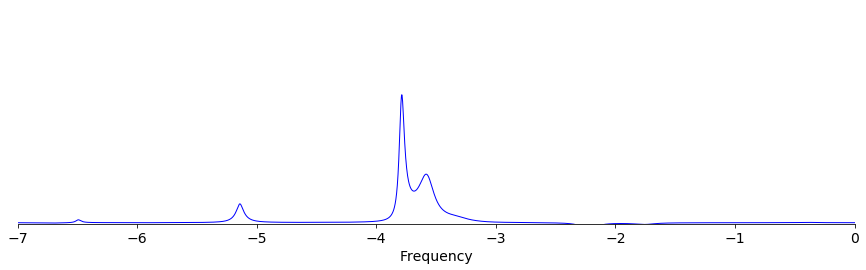

-3.7856213999999992
-0.21437860000000075


In [516]:
fig, ax = plt.subplots(1, 1, figsize=[15,4])
ax.plot(wlist / (2*pi), spec, 'b')
ax.set_xlim([-7, 0])
ax.set_ylim([0, max(wlist/2/pi)])
ax.set_xlabel('Frequency')
ax.set_ylabel('Power spectrum')
axn = plt.gca()
axn.axes.get_yaxis().set_visible(False)
axn.spines['top'].set_visible(False)
axn.spines['left'].set_visible(False)
axn.spines['right'].set_visible(False)
plt.show()
Max = wlist[spec.tolist().index(max(spec))]
print(eps/2/pi)
print(Max/2/pi)
print(-Max/2/pi-wq/2/pi)

We can also look at the two-time correlation function

\begin{equation}
    f_{2t}(\tau) = \left< \hat{b}(t + \tau) \hat{b}^\dagger(t) \right>
\end{equation}

and make a colour plot of it.

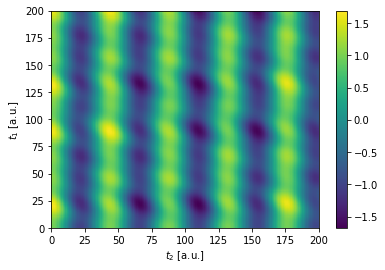

In [186]:
tlist = np.linspace(0, 0.7, 200)
corr = correlation_2op_2t(H, psi0, tlist, tlist, [], b, b.dag(), args=H_args)
pcolor(np.real(corr))
colorbar()
xlabel("$t_2$ [a.u.]")
ylabel("$t_1$ [a.u.]")
title("Two-time correlation function")
show()